# Introduction & Setup

Protein Structure Prediction is an important task in bioinformatics. Proteins are essential molecules in living organisms, and their function is determined by how they fold into 3D structures. The secondary structure prediction task involves predicting the local structure elements of a protein (such as helices, strands, and loops) based on the amino acid sequence.

Traditionally, these structures are determined using experimental techniques such as X-ray crystallography or NMR, which are expensive and time-consuming. Deep learning models like Convolutional Neural Networks (CNNs) offer a faster, computational approach to predict these secondary structures (sst3 and sst8) from the primary sequences of amino acids.

The goal of this project is to predict two levels of secondary structure from protein sequences:
1. **sst3**: Three-state secondary structure classification (helix, strand, coil).
2. **sst8**: Eight-state secondary structure classification for more granularity.

We will be focusing on CNNs as our deep learning approach to achieve this prediction.


#### Installation and Imports

In [ ]:
!pip install torch torchvision torchaudio
!pip install pandas matplotlib numpy scikit-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import seaborn as sns
import random
import os

# Set a fixed random seed for reproducibility
random_seed = 42  # You can choose any integer

# Set seed for Python's random module
random.seed(random_seed)

# Set seed for NumPy
np.random.seed(random_seed)

# Set seed for PyTorch (for CPU and GPU)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Data Loading & Analysis


#### Loading and Inspecting the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/Neural Networks Project/alfrandom/2018-06-06-pdb-intersect-pisces.csv"
df = pd.read_csv(file_path)

In [ ]:
print("First 5 rows of the dataset:")
print(df.head())

print("\nColumn Descriptions:")
print(df.columns)

First 5 rows of the dataset:
  pdb_id chain_code                   seq                  sst8  \
0   1FV1          F  NPVVHFFKNIVTPRTPPPSQ  CCCCCBCCCCCCCCCCCCCC   
1   1LM8          H  DLDLEMLAPYIPMDDDFQLR  CCCCCCCCCBCCSCCCEECC   
2   1O06          A  EEDPDLKAAIQESLREAEEA  CCCHHHHHHHHHHHHHHHTC   
3   1QOW          D  CTFTLPGGGGVCTLTSECI*  CCTTSCTTCSSTTSSTTCCC   
4   1RDQ          I  TTYADFIASGRTGRRNAIHD  CHHHHHHTSSCSSCCCCEEC   

                   sst3  len  has_nonstd_aa Exptl.  resolution  R-factor  \
0  CCCCCECCCCCCCCCCCCCC   20          False   XRAY        1.90      0.23   
1  CCCCCCCCCECCCCCCEECC   20          False   XRAY        1.85      0.20   
2  CCCHHHHHHHHHHHHHHHCC   20          False   XRAY        1.45      0.19   
3  CCCCCCCCCCCCCCCCCCCC   20           True   XRAY        1.06      0.14   
4  CHHHHHHCCCCCCCCCCEEC   20          False   XRAY        1.26      0.13   

   FreeRvalue  
0        0.27  
1        0.24  
2        0.22  
3        1.00  
4        0.16  

Column Descrip

####Sequence Length Distribution



Descriptive Statistics for Sequence Lengths:
count    9078.000000
mean      243.168539
std       156.566596
min        20.000000
25%       132.000000
50%       208.000000
75%       323.000000
max      1632.000000
Name: len, dtype: float64


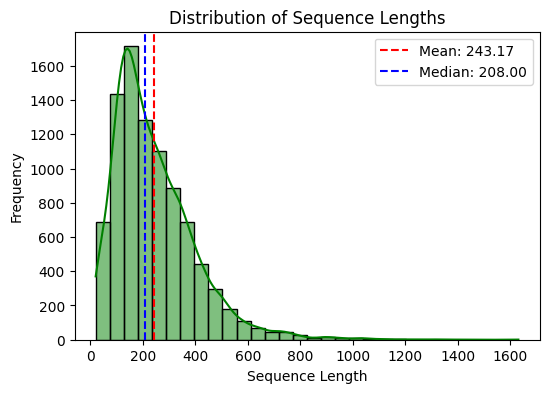

In [ ]:
# Descriptive statistics for sequence lengths
sequence_lengths = df['len']
print("\nDescriptive Statistics for Sequence Lengths:")
print(sequence_lengths.describe())

# Visualizing the distribution with descriptive statistics
plt.figure(figsize=(6, 4))
sns.histplot(sequence_lengths, bins=30, kde=True, color='green')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(sequence_lengths.mean(), color='r', linestyle='--', label=f'Mean: {sequence_lengths.mean():.2f}')
plt.axvline(sequence_lengths.median(), color='b', linestyle='--', label=f'Median: {sequence_lengths.median():.2f}')
plt.legend()
plt.show()



The data is skewed towards the left. The difference between the 3rd quartile & the mode is 1,309 - almost 80% of the data range. As a result, we can experiment with three different preprocessing techniques:
*   Drop out all data with lengths above $\mu + 2\sigma = 556$

*   Cropping & padding all data to 208 (Median), 323 (Q3), 556 ($\mu + 2\sigma$)

*   Keep all data & pad appropriately




Amino Acid Distribution in Sequences:
   Amino Acid   Count
0           L  201119
1           A  182067
2           G  161595
3           V  149918
4           E  146926
5           S  138543
6           D  131027
7           K  124431
8           I  121770
9           T  119745
10          R  112160
11          P  101815
12          N   95123
13          F   88481
14          Q   83134
15          Y   77474
16          H   63624
17          M   50765
18          W   31398
19          C   26213
20          *     156


<ipython-input-122-9901fb5726bc>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Amino Acid', y='Count', data=amino_acid_counts, palette='coolwarm')


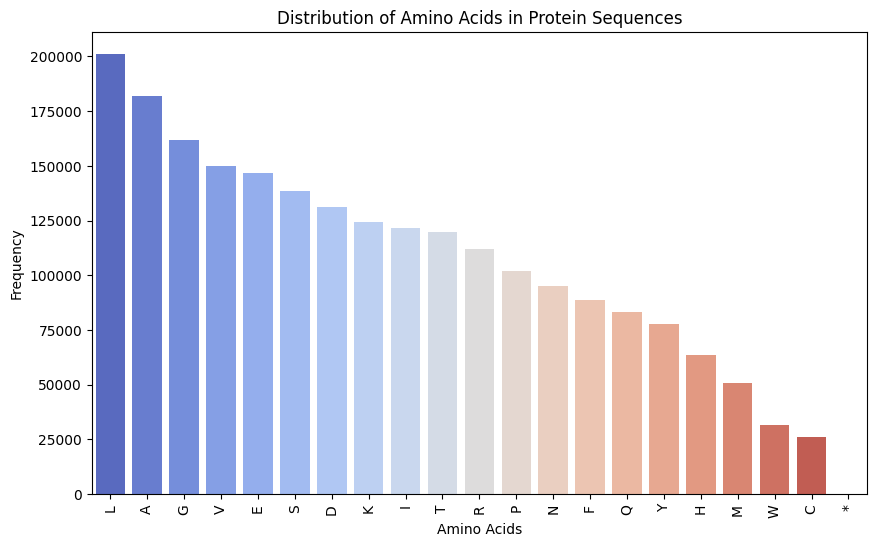


Distribution of Secondary Structure Letters (sst3):
  sst3 Structure   Count
0              C  938709
1              H  779825
2              E  488950


<ipython-input-122-9901fb5726bc>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sst3 Structure', y='Count', data=sst3_counts, palette='coolwarm')


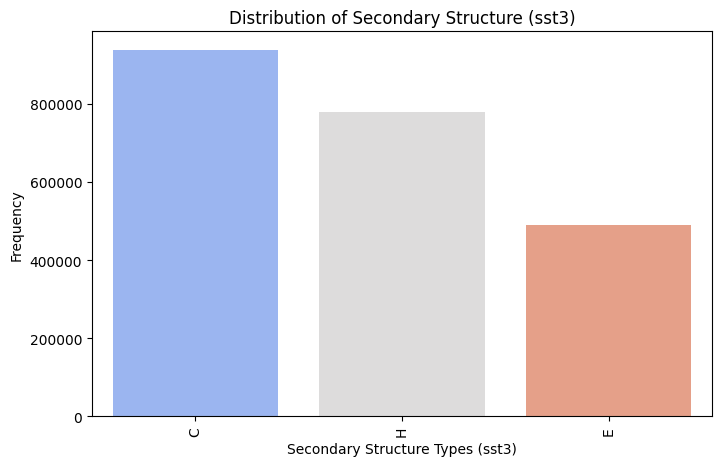


Distribution of Secondary Structure Letters (sst8):
  sst8 Structure   Count
0              H  696467
1              C  533636
2              E  465769
3              T  234594
4              S  170479
5              G   82972
6              B   23181
7              I     386


<ipython-input-122-9901fb5726bc>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sst8 Structure', y='Count', data=sst8_counts, palette='coolwarm')


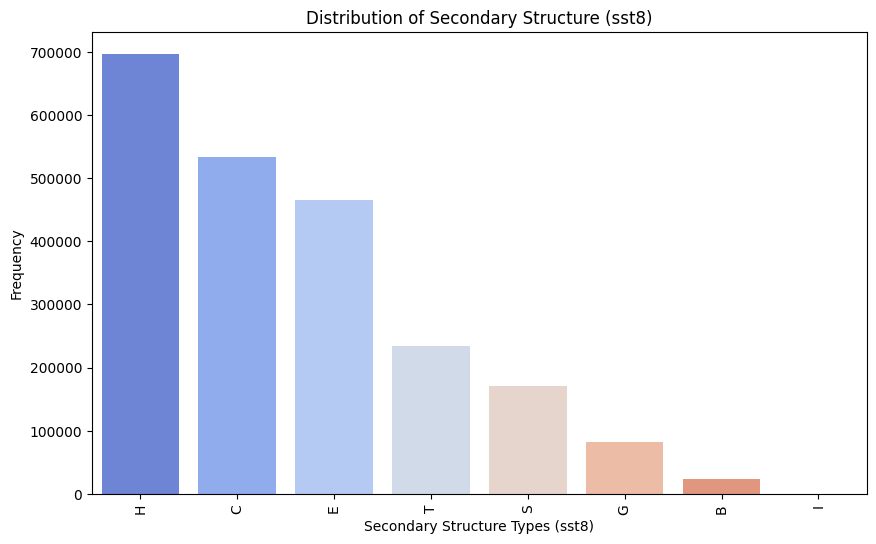

In [ ]:
# 2.3 Class Distribution Analysis - Fixed Version

# Amino Acid Distribution Table - Splitting all sequences into individual amino acids
amino_acid_series = pd.Series(list(''.join(df['seq'])))
amino_acid_counts = amino_acid_series.value_counts().reset_index()
amino_acid_counts.columns = ['Amino Acid', 'Count']

# Displaying the table with the amino acid counts
print("\nAmino Acid Distribution in Sequences:")
print(amino_acid_counts)

# Plotting the amino acid distribution (no limit on data size)
plt.figure(figsize=(10, 6))
sns.barplot(x='Amino Acid', y='Count', data=amino_acid_counts, palette='coolwarm')
plt.title('Distribution of Amino Acids in Protein Sequences')
plt.xlabel('Amino Acids')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# sst3 Structure Distribution Table
sst3_series = pd.Series(list(''.join(df['sst3'])))
sst3_counts = sst3_series.value_counts().reset_index()
sst3_counts.columns = ['sst3 Structure', 'Count']

# Displaying the table with sst3 counts
print("\nDistribution of Secondary Structure Letters (sst3):")
print(sst3_counts)

# Plotting the sst3 structure letter distribution
plt.figure(figsize=(8, 5))
sns.barplot(x='sst3 Structure', y='Count', data=sst3_counts, palette='coolwarm')
plt.title('Distribution of Secondary Structure (sst3)')
plt.xlabel('Secondary Structure Types (sst3)')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# sst8 Structure Distribution Table
sst8_series = pd.Series(list(''.join(df['sst8'])))
sst8_counts = sst8_series.value_counts().reset_index()
sst8_counts.columns = ['sst8 Structure', 'Count']

# Displaying the table with sst8 counts
print("\nDistribution of Secondary Structure Letters (sst8):")
print(sst8_counts)

# Plotting the sst8 structure letter distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='sst8 Structure', y='Count', data=sst8_counts, palette='coolwarm')
plt.title('Distribution of Secondary Structure (sst8)')
plt.xlabel('Secondary Structure Types (sst8)')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


There is clearly class imbalance between the different amino-acids, and secondary structures. As a result, we will proceed with the following approaches:


*   List item
*   List item




#Data Preprocessing

#### Pre-processing Parameters

In [ ]:

# 1. Set the cutoff length for filtering sequences based on user-defined or data-driven values.
# The default value is the maximum sequence length in the dataset, but this can be adjusted by the user.
cutoff_length = 132  # Default is the max sequence length in the data

# 2. Define the padding/cropping length for sequences.
# The initial value is set to the maximum sequence length, but it can be varied.
padding_length = cutoff_length  # Default padding length

# 3. Boolean parameter to determine whether to filter out sequences containing non-standard amino acids.
# True indicates filtering out non-standard amino acids, while False keeps them.
filter_non_standard = False  # Default value is True (filter out non-standard amino acids)

# 4. Embedding method for encoding the protein sequences.
# Options: "one_hot" for one-hot encoding, "learnable" for learnable embeddings, "ProtBERT" or "TAPE" for pretrained embeddings.
embedding_method = "one_hot"  # Default embedding method



#### Filtering, Cropping, Padding & Encoding


In [ ]:
sst3_vocab = sorted(set([char for sst in df['sst3'] for char in sst]))
q3_stoi = {char: i for i, char in enumerate(sst3_vocab)}
q3_itos = {i: char for char, i in q3_stoi.items()}

# For sst8
sst8_vocab = sorted(set([char for sst in df['sst8'] for char in sst] + ['.']))
q8_stoi = {char: i for i, char in enumerate(sst8_vocab)}
q8_itos = {i: str(j) for i, j in enumerate(sst8_vocab)}

seq_vocab = sorted(set([char for seq in df['seq'] for char in seq] + ['.']))
seq_stoi = {char: i for i, char in enumerate(seq_vocab)}
padding_idx = seq_stoi['.']  # The index assigned to the padding character in input sequences
seq_itos = {i: str(j) for i, j in enumerate(seq_vocab)}


# Preprocessing function
def preprocess_data(df, cutoff_length, padding_length, filter_non_standard, embedding_method):
    """
    Preprocess the data according to user-defined parameters.
    Args:
    - df (DataFrame): Original dataset.
    - cutoff_length (int): Cutoff sequence length. Only sequences with a length <= cutoff_length are kept.
    - padding_length (int): Length to which sequences will be padded or cropped.
    - filter_non_standard (bool): If True, sequences with non-standard amino acids will be filtered out.
    - embedding_method (str): Embedding method to use ('one_hot', 'learnable', 'ProtBERT', 'TAPE').
    Returns:
    - Processed DataFrame.
    """
    # Step 1: Remove sequences with missing 'seq' or 'sst3'
    df_filtered = df.dropna(subset=['seq', 'sst3'])

    # Step 2: Filter out sequences where 'seq' and 'sst3' lengths do not match
    df_filtered = df_filtered[df_filtered['seq'].str.len() == df_filtered['sst3'].str.len()]

    # Step 3: Filter out sequences based on cutoff length
    df_filtered = df_filtered[df_filtered['len'] <= cutoff_length]

    # Step 4: Optionally filter out sequences with non-standard amino acids
    if filter_non_standard:
        df_filtered = df_filtered[df_filtered['has_nonstd_aa'] == False]

    # Step 5: Padding and Cropping Sequences to the specified length (padding_length)
    def pad_or_crop_sequence(seq, target_len):
        if len(seq) < target_len:
            return seq + '.' * (target_len - len(seq))  # Pad with dots for sequences shorter than target_len
        else:
            return seq[:target_len]  # Crop for sequences longer than target_len

    df_filtered['seq'] = df_filtered['seq'].apply(lambda x: pad_or_crop_sequence(x, padding_length))
    df_filtered['sst3'] = df_filtered['sst3'].apply(lambda x: pad_or_crop_sequence(x, padding_length))
    df_filtered['sst8'] = df_filtered['sst8'].apply(lambda x: pad_or_crop_sequence(x, padding_length))

    # Step 6: Encoding the sequences based on the specified embedding method
    def encode_sequence(sequence, embedding_method):
        if embedding_method == 'one_hot':
            return [seq_stoi[char] for char in sequence]  # One-hot encoding using string-to-int mapping
        elif embedding_method == 'learnable':
            return [seq_stoi[char] for char in sequence]  # Same encoding, but embedding layer will be learned later
        elif embedding_method == 'ProtBERT':
            # Code to encode with ProtBERT embeddings would go here (placeholder for future implementation)
            raise NotImplementedError("ProtBERT embedding is not yet implemented.")
        elif embedding_method == 'TAPE':
            # Code to encode with TAPE embeddings would go here (placeholder for future implementation)
            raise NotImplementedError("TAPE embedding is not yet implemented.")
        else:
            raise ValueError(f"Invalid embedding method: {embedding_method}")

    # Add label encoding for sst3
    df_filtered['encoded_sst3'] = df_filtered['sst3'].apply(lambda x: encode_labels(x))

    # Add label encoding for sst8 (if you're working with sst8 as well)
    df_filtered['encoded_sst8'] = df_filtered['sst8'].apply(lambda x: [q8_stoi[char] for char in x])

    # Apply encoding based on the selected embedding method
    df_filtered['encoded_seq'] = df_filtered['seq'].apply(lambda x: encode_sequence(x, embedding_method))

    return df_filtered

def encode_labels(labels):
    return [q3_stoi[char] if char in q3_stoi else -100 for char in labels]
# Check for missing 'sst3' before preprocessing
print(f"Number of sequences with missing 'sst3': {df['sst3'].isnull().sum()}")

# Check for sequences where 'seq' and 'sst3' lengths do not match
length_mismatch = df[df['seq'].str.len() != df['sst3'].str.len()]
print(f"Number of sequences where 'seq' and 'sst3' lengths do not match: {len(length_mismatch)}")

# Run the preprocessing with current parameters
df_preprocessed = preprocess_data(df, cutoff_length, padding_length, filter_non_standard, embedding_method)

# Display the number of sequences after preprocessing
print(f"Number of sequences before preprocessing: {len(df)}")
print(f"Number of sequences after preprocessing: {len(df_preprocessed)}")

# Apply the updated seq_stoi to encode sequences
df_preprocessed['encoded_seq'] = df_preprocessed['seq'].apply(lambda x: [seq_stoi[char] for char in x])
df_preprocessed['encoded_sst3'] = df_preprocessed['sst3'].apply(lambda x: encode_labels(x))
df_preprocessed['encoded_sst8'] = df_preprocessed['sst8'].apply(lambda x: [q8_stoi[char] for char in x])

# Display the head of the preprocessed dataset to verify the changes
df_preprocessed[['chain_code', 'sst3', 'sst8', 'encoded_seq', 'encoded_sst3', 'encoded_sst8']].head()


Number of sequences with missing 'sst3': 0
Number of sequences where 'seq' and 'sst3' lengths do not match: 0
Number of sequences before preprocessing: 9078
Number of sequences after preprocessing: 2292


,chain_code,sst3,sst8,encoded_seq,encoded_sst3,encoded_sst8
0,F,CCCCCECCCCCCCCCCCCCC.............................,CCCCCBCCCCCCCCCCCCCC.............................,"[13, 14, 19, 19, 8, 6, 6, 10, 13, 9, 19, 18, 1...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1,H,CCCCCCCCCECCCCCCEECC.............................,CCCCCCCCCBCCSCCCEECC.............................,"[4, 11, 4, 11, 5, 12, 11, 2, 14, 21, 9, 14, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 7, 2, 2, ..."
2,A,CCCHHHHHHHHHHHHHHHCC.............................,CCCHHHHHHHHHHHHHHHTC.............................,"[5, 5, 4, 14, 4, 11, 10, 2, 2, 9, 15, 5, 17, 1...","[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
3,D,CCCCCCCCCCCCCCCCCCCC.............................,CCTTSCTTCSSTTSSTTCCC.............................,"[3, 18, 6, 18, 11, 14, 7, 7, 7, 7, 19, 3, 18, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 8, 8, 7, 2, 8, 8, 2, 7, 7, 8, 8, 7, 7, ..."
4,I,CHHHHHHCCCCCCCCCCEEC.............................,CHHHHHHTSSCSSCCCCEEC.............................,"[18, 18, 21, 2, 4, 6, 9, 2, 17, 7, 16, 18, 7, ...","[0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 5, 5, 5, 5, 5, 5, 8, 7, 7, 2, 7, 7, 2, 2, ..."


#Data Preparation


####Preparation Parameters

In [ ]:
# Parametric Option for split method and batch sizes
split_method = 'random'  # The default splitting method is random (80-10-10)
train_val_test_split = [0.8, 0.1, 0.1]

#DataLoader Parameters
batch_size = 64  # Parametric Option: Can be changed to 32, 64, 128, etc.


####Splitting and Dataloader

In [ ]:
# 4.2 Splitting the Dataset
from sklearn.model_selection import train_test_split

def split_dataset(df, split_method, train_val_test_split):
    """
    Splits the dataset into training, validation, and test sets.
    Args:
    - df (DataFrame): Preprocessed dataset.
    - split_method (str): Method to split the dataset. Currently, only 'random' is supported.
    - train_val_test_split (list): Proportions for train, val, and test sets (e.g., [0.8, 0.1, 0.1]).
    Returns:
    - train_df, val_df, test_df: DataFrames for train, validation, and test sets.
    """
    if split_method == 'random':
        train_df, temp_df = train_test_split(df, test_size=(1 - train_val_test_split[0]), random_state=42)
        val_df, test_df = train_test_split(temp_df, test_size=(train_val_test_split[2] / (train_val_test_split[1] + train_val_test_split[2])), random_state=42)
    else:
        raise ValueError(f"Unsupported split method: {split_method}")

    return train_df, val_df, test_df

# Example of splitting the dataset
train_df, val_df, test_df = split_dataset(df_preprocessed, split_method, train_val_test_split)

# 4.3 Custom Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader

class ProteinDataset(Dataset):
    """Custom PyTorch Dataset for protein sequences."""
    def __init__(self, df, label_column):
        """
        Args:
        - df (DataFrame): DataFrame containing the dataset.
        - label_column (str): Column name for the labels (encoded_sst3 or encoded_sst8).
        """
        self.sequences = df['encoded_seq'].values  # Ensure this column contains encoded numerical sequences
        self.labels = df[label_column].values  # This should contain the encoded labels (either encoded_sst3 or encoded_sst8)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert sequences and labels to PyTorch tensors
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


def initialize_dataloaders(train_df, val_df, test_df, batch_size, label_column):
    """Creates DataLoaders for train, validation, and test sets."""
    train_dataset = ProteinDataset(train_df, label_column)
    val_dataset = ProteinDataset(val_df, label_column)
    test_dataset = ProteinDataset(test_df, label_column)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Example usage: initializing dataloaders for the train, val, and test sets
label_column = 'encoded_sst3'  # or 'encoded_sst8' depending on what you are predicting
train_loader, val_loader, test_loader = initialize_dataloaders(train_df, val_df, test_df, batch_size, label_column)


# Displaying the sizes of each split
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Training set size: 1833
Validation set size: 229
Test set size: 230


In [ ]:
# Create the directory if it doesn't exist using shell command
!mkdir -p '/content/drive/My Drive/Neural Networks Project/Split_Data'

# Save the split datasets to CSV files in Google Drive
train_df.to_csv('/content/drive/My Drive/Neural Networks Project/Split_Data/train_data.csv', index=False)
val_df.to_csv('/content/drive/My Drive/Neural Networks Project/Split_Data/val_data.csv', index=False)
test_df.to_csv('/content/drive/My Drive/Neural Networks Project/Split_Data/test_data.csv', index=False)

# Confirm the files have been saved
print("Train, validation, and test data saved successfully in Google Drive.")


Train, validation, and test data saved successfully in Google Drive.


#Model Architecture

####Model Hyperparameters

In [ ]:
# Initialize hyperparameters for the CNN architecture
embedding_dim = 128   # Dimension of the embedding layer
num_filters = 64      # Number of filters in each convolutional layer
kernel_sizes = [3, 5, 7]  # List of kernel sizes for multiple convolutional layers
dropout_rate = 0.5    # Dropout rate for regularization
fc_units = 256        # Number of units in the fully connected (dense) layer
num_classes = len(sst3_vocab)       # Number of classes including the padding index
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 20       # Number of training epochs


####CNN Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProteinCNN(nn.Module):
    def __init__(self, embedding_dim, num_filters, kernel_sizes, dropout_rate, fc_units, num_classes):
        super(ProteinCNN, self).__init__()

        # Use the correct padding_idx
        padding_idx = seq_stoi['.']

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=len(seq_stoi), embedding_dim=embedding_dim, padding_idx=padding_idx)

        # Convolutional Layers with different kernel sizes
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=ks, padding=ks // 2)
            for ks in kernel_sizes
        ])

        # Batch Normalization layers for Conv layers
        self.conv_batchnorms = nn.ModuleList([
            nn.BatchNorm1d(num_features=num_filters)
            for _ in kernel_sizes
        ])

        # Nonlinear Activation Functions for Conv Layers
        self.conv_activations = nn.ModuleList([
            nn.ReLU()
            for _ in kernel_sizes
        ])

        # Fully Connected Layer
        conv_output_size = num_filters * len(kernel_sizes)
        self.fc = nn.Linear(conv_output_size, fc_units)

        # Batch Normalization after Fully Connected Layer
        self.fc_batchnorm = nn.BatchNorm1d(num_features=fc_units)

        # Activation function after the fully connected layer
        self.fc_activation = nn.ReLU()

        # Dropout Layer
        self.dropout = nn.Dropout(dropout_rate)

        # Output Layer
        self.output = nn.Linear(fc_units, num_classes)

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embedding_dim)
        x = x.permute(0, 2, 1)  # Shape: (batch_size, embedding_dim, seq_length)

        # Apply convolutional layers with batch norm and activation functions
        conv_results = []
        for conv_layer, batchnorm, activation in zip(self.conv_layers, self.conv_batchnorms, self.conv_activations):
            conv_output = conv_layer(x)  # (batch_size, num_filters, seq_length)
            conv_output = batchnorm(conv_output)
            activated_output = activation(conv_output)
            conv_results.append(activated_output)

        # Concatenate the outputs from different convolutional layers
        x = torch.cat(conv_results, dim=1)  # Shape: (batch_size, total_num_filters, seq_length)

        # Permute to have sequence length in the second dimension
        x = x.permute(0, 2, 1)  # Shape: (batch_size, seq_length, total_num_filters)

        # Apply the fully connected layer to each residue
        x = self.fc(x)  # Shape: (batch_size, seq_length, fc_units)
        x = self.fc_batchnorm(x.transpose(1, 2)).transpose(1, 2)  # BatchNorm over features
        x = self.fc_activation(x)

        # Dropout
        x = self.dropout(x)

        # Output layer
        x = self.output(x)  # Shape: (batch_size, seq_length, num_classes)

        # Reshape outputs if necessary
        x = x.view(-1, num_classes)  # Prepare for loss computation

        return x



#Training

#### Training Parameters

In [ ]:
# Early stopping
use_early_stopping = True  # Toggle this to turn early stopping on/off
early_stopping_patience = 5  # Number of epochs to wait for improvement in validation loss

# Learning rate scheduling
use_lr_scheduler = True  # Toggle this to use a learning rate scheduler or not
scheduler_type = 'ReduceLROnPlateau'  # Options: 'StepLR', 'ReduceLROnPlateau'
step_size = 5  # For StepLR, decay learning rate every `step_size` epochs
gamma = 0.1  # Factor by which the learning rate is reduced
min_lr = 1e-6  # Minimum learning rate for ReduceLROnPlateau

# Training hyperparameters
num_epochs = 20
learning_rate = 0.001

# Initialize the model
model = ProteinCNN(
    embedding_dim=embedding_dim,
    num_filters=num_filters,
    kernel_sizes=kernel_sizes,
    dropout_rate=dropout_rate,
    fc_units=fc_units,
    num_classes=num_classes
).to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



####Training Loop

In [ ]:
def validate_model(model, val_loader, loss_fn):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            # Reshape outputs and targets for loss computation
            outputs = outputs.view(-1, num_classes)
            targets = targets.view(-1)

            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss

# Define the training loop
def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs, use_early_stopping, use_lr_scheduler, scheduler_type):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    if use_lr_scheduler:
        if scheduler_type == 'StepLR':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_type == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=early_stopping_patience, min_lr=min_lr)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0

        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Clear gradients from previous step

            # Forward pass
            outputs = model(inputs)

            # Reshape outputs and targets for loss computation
            outputs = outputs.view(-1, num_classes)
            targets = targets.view(-1)

            loss = loss_fn(outputs, targets)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        val_loss = validate_model(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        # Optionally use learning rate scheduler
        if use_lr_scheduler:
            if scheduler_type == 'StepLR':
                scheduler.step()  # StepLR scheduler reduces LR every step_size epochs
            elif scheduler_type == 'ReduceLROnPlateau':
                scheduler.step(val_loss)  # ReduceLROnPlateau scheduler adjusts based on validation loss

        # Early stopping mechanism
        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset patience if improvement is seen
                # Save the best model so far
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    print("Training completed.")
    return model, train_losses, val_losses





In [ ]:
max_index = max([max(seq) for seq in df_preprocessed['encoded_seq']])
print(f"Maximum index in encoded sequences: {max_index}")
print(f"Vocabulary size (num_embeddings): {len(seq_stoi)}")


Maximum index in encoded sequences: 21
Vocabulary size (num_embeddings): 22


In [ ]:
# Call the train function with the parametric options
trained_model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=num_epochs,
    use_early_stopping=use_early_stopping,
    use_lr_scheduler=use_lr_scheduler,
    scheduler_type=scheduler_type
)

Epoch [1/20], Training Loss: 0.9096, Validation Loss: 0.8461
Epoch [2/20], Training Loss: 0.8273, Validation Loss: 0.7957
Epoch [3/20], Training Loss: 0.7995, Validation Loss: 0.7759
Epoch [4/20], Training Loss: 0.7836, Validation Loss: 0.7756
Epoch [5/20], Training Loss: 0.7738, Validation Loss: 0.7814
Epoch [6/20], Training Loss: 0.7692, Validation Loss: 0.7859
Epoch [7/20], Training Loss: 0.7645, Validation Loss: 0.7694
Epoch [8/20], Training Loss: 0.7592, Validation Loss: 0.7649
Epoch [9/20], Training Loss: 0.7545, Validation Loss: 0.7730
Epoch [10/20], Training Loss: 0.7509, Validation Loss: 0.7647
Epoch [11/20], Training Loss: 0.7476, Validation Loss: 0.7676
Epoch [12/20], Training Loss: 0.7507, Validation Loss: 0.7719
Epoch [13/20], Training Loss: 0.7408, Validation Loss: 0.7710
Epoch [14/20], Training Loss: 0.7358, Validation Loss: 0.7732
Early stopping triggered after 15 epochs.
Training completed.


#Model Evaluation

####Evaluate Model Performance


In [ ]:
# Load the best model saved during training
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


<ipython-input-134-9716386bb048>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


ProteinCNN(
  (embedding): Embedding(22, 128, padding_idx=1)
  (conv_layers): ModuleList(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(128, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  )
  (conv_batchnorms): ModuleList(
    (0-2): 3 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_activations): ModuleList(
    (0-2): 3 x ReLU()
  )
  (fc): Linear(in_features=192, out_features=256, bias=True)
  (fc_batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_loader, loss_fn):
    all_preds = []
    all_targets = []
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Reshape outputs and targets for loss computation and metric calculations
            outputs = outputs.view(-1, num_classes)
            targets = targets.view(-1)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            # Get the predicted classes
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy())

    average_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=1)

    return average_loss, accuracy, precision, recall, f1, all_targets, all_preds


In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, all_targets, all_preds = evaluate_model(
    model, test_loader, loss_fn
)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')


Test Loss: 0.7904
Test Accuracy: 0.4439
Test Precision: 0.6662
Test Recall: 0.4439
Test F1 Score: 0.3709


####Visualize Model Performance

Valid labels after filtering: [0, 1, 2]


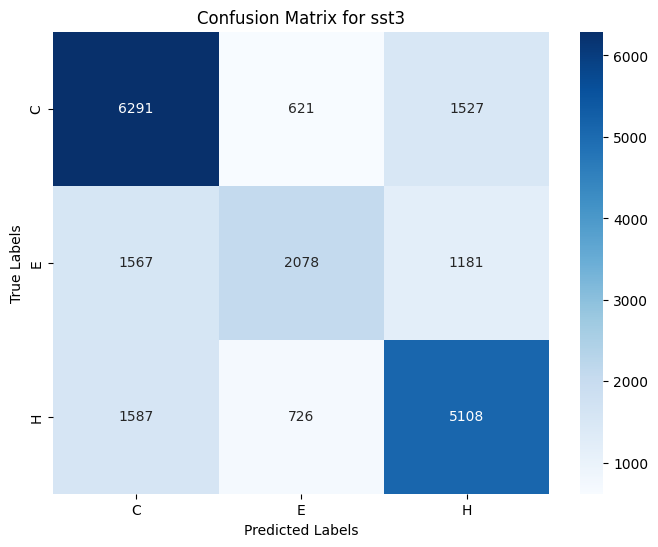

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    # Convert to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Exclude padding positions (where y_true == -100)
    mask = y_true != -100
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    # Verify that y_true_filtered and y_pred_filtered contain valid class labels
    valid_labels = sorted(set(y_true_filtered) | set(y_pred_filtered))
    print(f"Valid labels after filtering: {valid_labels}")

    # Generate confusion matrix with the filtered data
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=valid_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[q3_itos[label] for label in valid_labels],
                yticklabels=[q3_itos[label] for label in valid_labels])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Generate and plot confusion matrix for the test set
plot_confusion_matrix(all_targets, all_preds, class_names=sst3_vocab, title='Confusion Matrix for sst3')


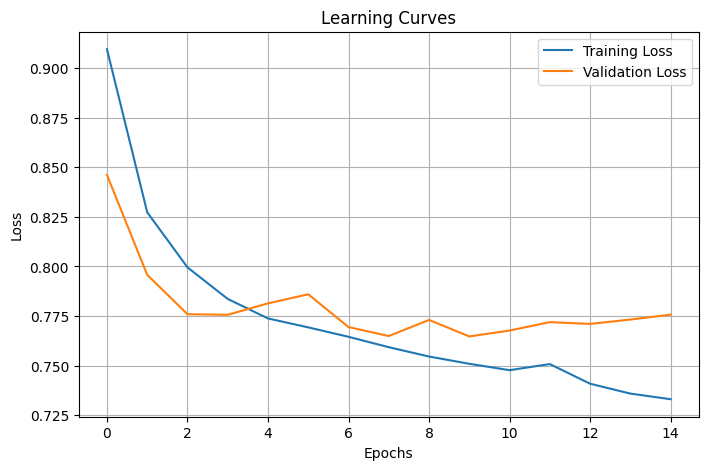

In [ ]:
def plot_learning_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming train_losses and val_losses are collected during training
plot_learning_curves(train_losses, val_losses)


####Analyze Misclassifications

In [ ]:
from IPython.display import display, HTML

def decode_labels(encoded_labels, itos):
    """
    Converts a list of encoded labels back to their original string representations.
    Args:
    - encoded_labels (list): List of encoded numerical labels.
    - itos (dict): Integer-to-string mapping dictionary.

    Returns:
    - decoded_labels (list): List of decoded string labels.
    """
    decoded_labels = []
    for label in encoded_labels:
        if label == -100:
            decoded_labels.append('.')  # Use '.' or any placeholder for padding
        else:
            decoded_labels.append(itos[label])
    return decoded_labels

def analyze_misclassifications(y_true, y_pred, sequences, itos, num_examples=5):
    """
    Analyzes misclassified sequences by comparing true and predicted labels.
    Highlights misclassified positions in red using HTML.
    Args:
    - y_true (list): List of true encoded labels (flattened).
    - y_pred (list): List of predicted encoded labels (flattened).
    - sequences (list): List of original sequences (with padding).
    - itos (dict): Integer-to-string mapping dictionary.
    - num_examples (int): Number of examples to display.
    """
    errors = []
    idx = 0  # Index in the flattened y_true and y_pred lists

    for seq in sequences:
        # Calculate the actual length of the sequence (excluding padding)
        seq_len = len(seq.replace('.', ''))

        # Extract the true and predicted labels for the actual sequence length
        true_seq = y_true[idx:idx + seq_len]
        pred_seq = y_pred[idx:idx + seq_len]

        # Decode the labels
        decoded_true_seq = decode_labels(true_seq, itos)
        decoded_pred_seq = decode_labels(pred_seq, itos)

        # Check if there is a misclassification
        if decoded_true_seq != decoded_pred_seq:
            errors.append((seq[:seq_len], decoded_true_seq, decoded_pred_seq))

        # Move index by the padded sequence length
        idx += len(seq)

    print(f"Number of misclassified sequences: {len(errors)}")
    print("Sample misclassified sequences:")

    # Display a few misclassified examples
    for seq, true_seq, pred_seq in errors[:num_examples]:
        display(HTML(f"<strong>Sequence:</strong> {seq}"))
        true_label_str = ''.join(true_seq)
        pred_label_str = ''
        for t, p in zip(true_seq, pred_seq):
            if t != p:
                # Highlight misclassified positions in red
                pred_label_str += f"<span style='color:red;'>{p}</span>"
            else:
                pred_label_str += p
        display(HTML(f"<strong>True Label:</strong> {true_label_str}<br><strong>Predicted Label:</strong> {pred_label_str}"))
        display(HTML('<hr>'))




analyze_misclassifications(all_targets, all_preds, test_df['seq'].values, q3_itos, num_examples=100)


Number of misclassified sequences: 229
Sample misclassified sequences:
